## Challenge: random forest models

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do:

1. Pick a dataset. It could be one you've worked with before or it could be a new one. 
1. Then build the best **decision tree** you can.
1. Now try to match that with the simplest **random forest** you can. For our purposes measure simplicity with runtime. 
1. Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

In [111]:
import time
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

In [112]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [113]:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [114]:
# this dataset has a huge number of columns
house_prices.shape

(1460, 81)

## Binary classifer comparison - identify if a house is within a specific neighborhood

In [115]:
# how many houses are in each neighborhood
house_prices.neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: neighborhood, dtype: int64

In [116]:
# which neighborhoods have the highest mean home value?
house_prices[['neighborhood', 'saleprice']].groupby('neighborhood').mean().sort_values(by= 'saleprice', ascending=False).head()

,saleprice
neighborhood,
NoRidge,335295.317073
NridgHt,316270.623377
StoneBr,310499.000000
Timber,242247.447368
Veenker,238772.727273


In [117]:
# numerical features I'm interested in
X = house_prices[[x.lower() for x in ['OverallQual',
                                    'OverallCond', 
                                    'GrLivArea',
                                    'bedroomabvgr'
                                    ]]].copy()

In [118]:
X.head()

,overallqual,overallcond,grlivarea,bedroomabvgr
0,7,5,1710,3
1,6,8,1262,3
2,7,5,1786,3
3,7,5,1717,3
4,8,5,2198,4


In [119]:
# create target variable
# is a house in the NoRidge neighborhood or not

pd.get_dummies(house_prices.neighborhood).loc[:,'NoRidge']

0       0
1       0
2       0
3       0
4       1
       ..
1455    0
1456    0
1457    0
1458    0
1459    0
Name: NoRidge, Length: 1460, dtype: uint8

In [120]:
Y = pd.get_dummies(house_prices.neighborhood).loc[:,'NoRidge']

### Decision Tree Model

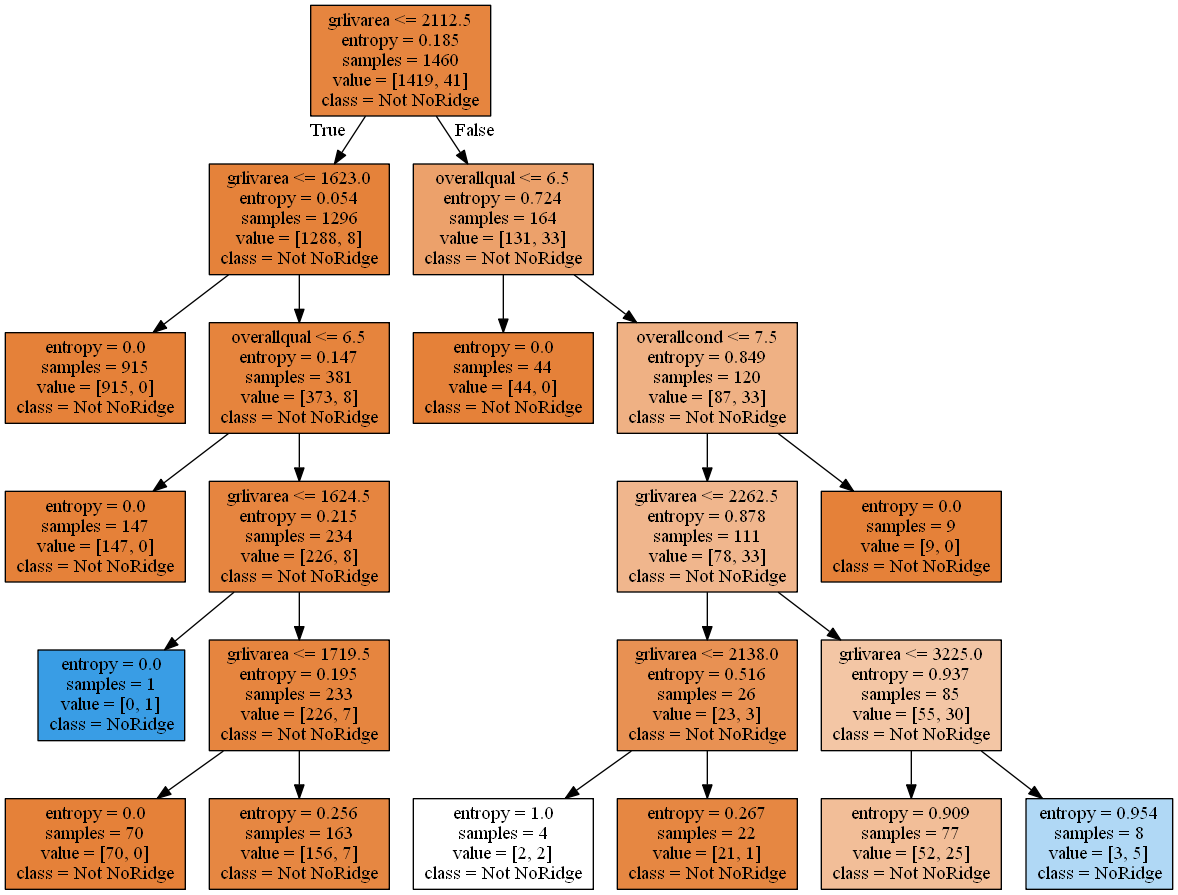

In [121]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=5)

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not NoRidge', 'NoRidge'], # how do I know what these names are being assigned to?
    filled=True                             # doest he order of these matter?
)
    
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [122]:
# decision_tree.fit(X, Y)
cross_val_score(rfc, X, Y, cv=10)

array([0.96598639, 0.97260274, 0.97260274, 0.97260274, 0.97260274,
       0.96575342, 0.97260274, 0.97260274, 0.97260274, 0.97241379])

In [123]:
# time decision tree model
start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4)

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not NoRidge', 'NoRidge'], # how do I know what these names are being assigned to?
    filled=True                             # doest he order of these matter?
)
    
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

--- 0.44 seconds ---


### Random Forest Model

In [124]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, Y)
cross_val_score(rfc, X, Y, cv=10)

array([0.96598639, 0.97260274, 0.97260274, 0.97260274, 0.97260274,
       0.97260274, 0.97260274, 0.97260274, 0.97260274, 0.97241379])

In [125]:
# time random forest model
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
start_time = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, Y)
cross_val_score(rfc, X, Y, cv=10)
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

--- 1.37 seconds ---


## Classifer comparison - identify if a house price falls within a range of values

In [126]:
# numerical features I'm interested in
X = house_prices[[x.lower() for x in ['OverallQual',
                                    'OverallCond', 
                                    'GrLivArea',
                                    'bedroomabvgr'
                                    ]]].copy()

In [127]:
# add categorical features

X = pd.concat((X, pd.get_dummies(house_prices.neighborhood)), axis=1)

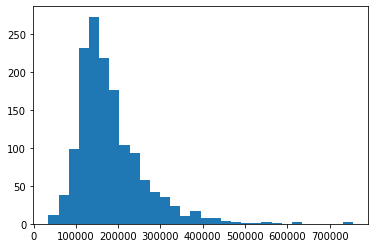

In [128]:
plt.hist(house_prices.saleprice, bins=30);

In [129]:
def bin_house(x):
    if x < 150000:
        return 'Low'
    elif x > 300000:
        return 'High'
    else:
        return 'Medium'

In [130]:
# create target variable
# three house value categories
Y = house_prices.saleprice.apply(bin_house)

### Decision Tree Model

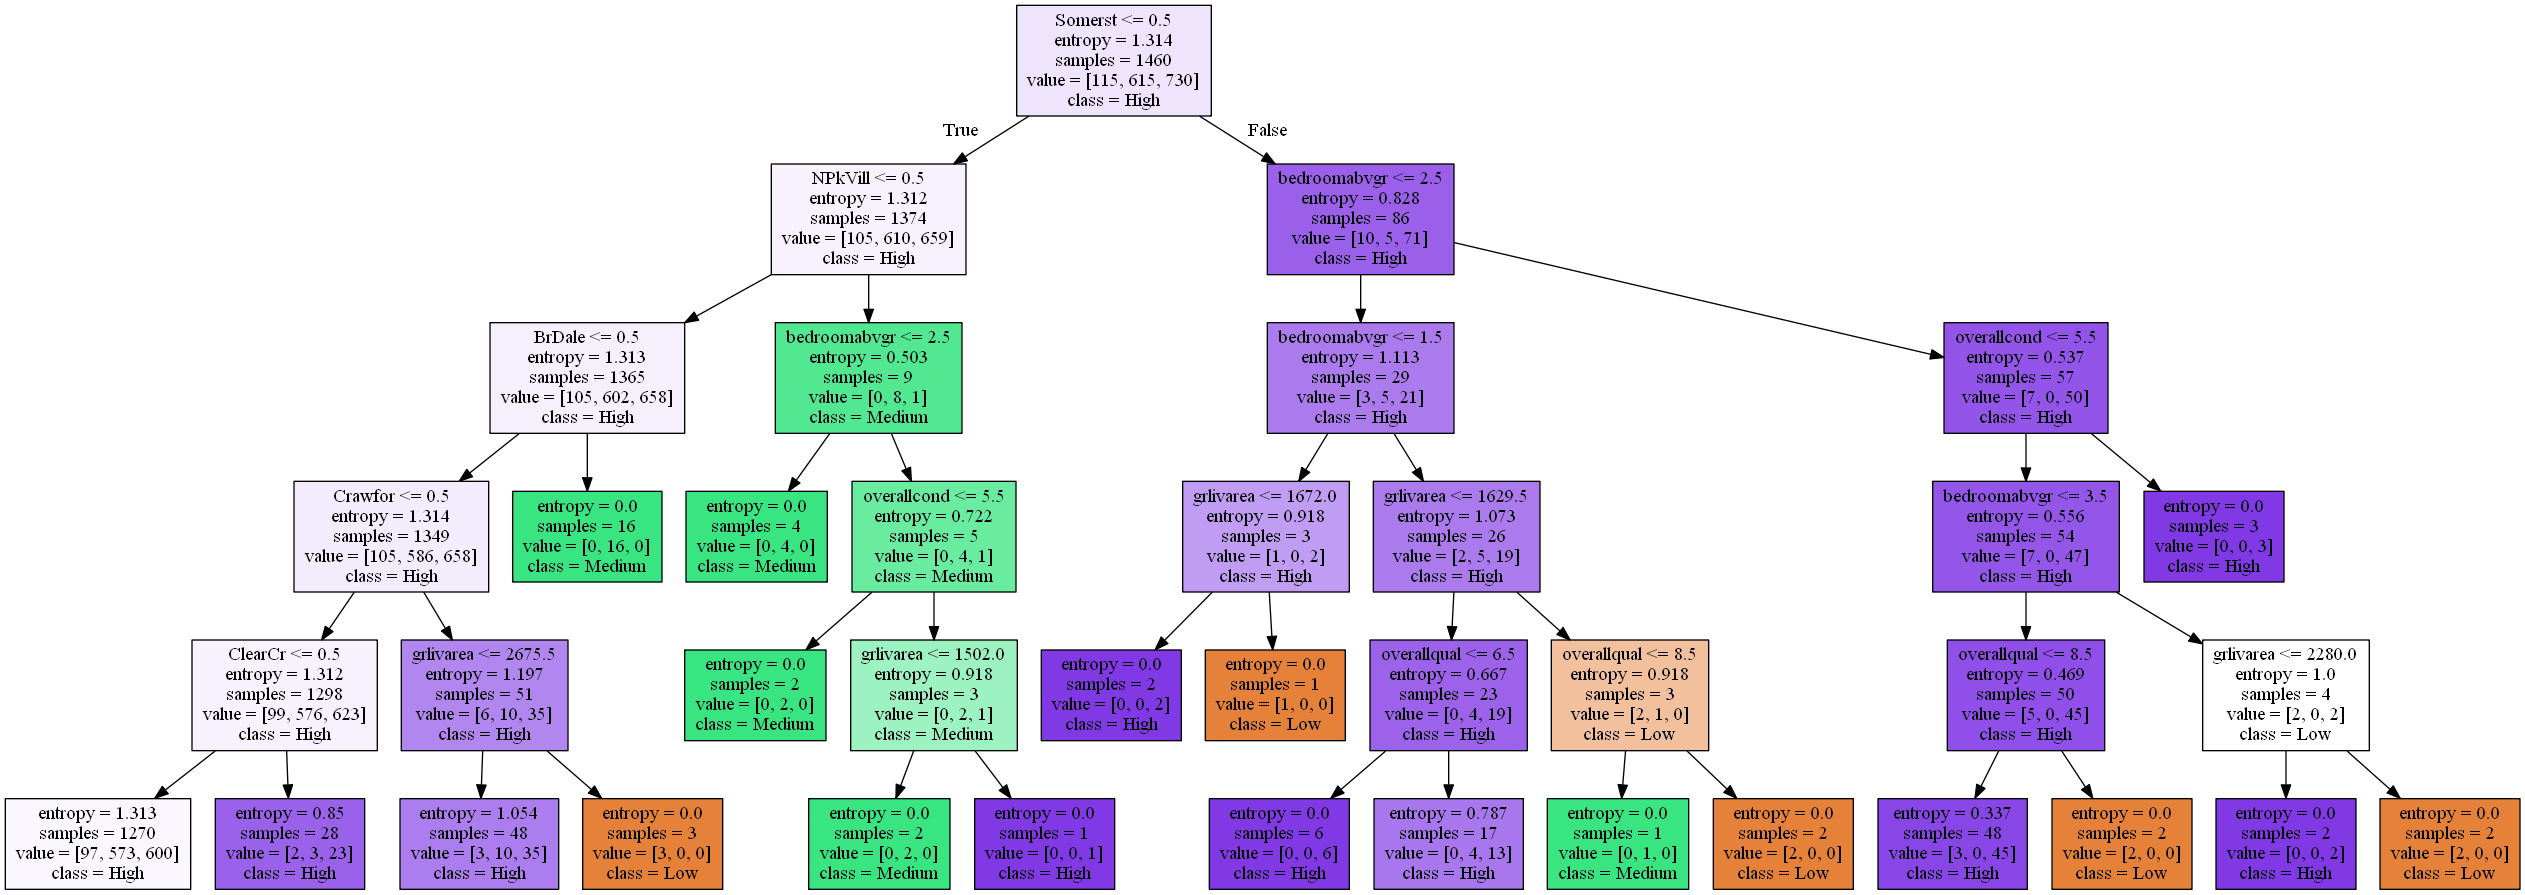

In [131]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5)

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Low', 'Medium', 'High'], # how do I know what these names are being assigned to?
    filled=True                             # doest he order of these matter?
)
    
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [132]:
# time decision tree model
start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5)

decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Low', 'Medium', 'High'], # how do I know what these names are being assigned to?
    filled=True                             # doest he order of these matter?
)
    
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

--- 0.53 seconds ---


In [148]:
f_importances = pd.DataFrame(decision_tree.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [150]:
f_importances.head()

,importance
NridgHt,0.380751
grlivarea,0.181720
Somerst,0.156474
StoneBr,0.123560
bedroomabvgr,0.055293


### Random Forest Model

In [133]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, Y)
cross_val_score(rfc, X, Y, cv=10)

array([0.80272109, 0.80272109, 0.82993197, 0.82312925, 0.76190476,
       0.79310345, 0.8137931 , 0.77931034, 0.75172414, 0.82758621])

In [134]:
# time random forest model
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
start_time = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, Y)
cross_val_score(rfc, X, Y, cv=10)
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

--- 1.43 seconds ---
